# Project About

This project explores how different classification algorithms behave when applied to a highly structured educational dataset. The Student Performance dataset contains exam scores and demographic attributes that are strongly correlated with academic outcomes.

Rather than treating classification accuracy as the sole objective, this analysis focuses on understanding how model complexity, feature structure, and dataset characteristics influence predictive performance. By comparing Logistic Regression, Decision Trees, and ensemble methods, the project highlights how certain datasets can lead to deceptively high evaluation scores and why interpretability and generalisation must be considered alongside accuracy.

The almost-perfect performance seen in simpler models is mostly because of the direct relationship between exam scores and performance categories. The dataset has strong linear separability because the target variable is based on score thresholds. As a result, even basic classifiers can achieve extremely high accuracy, making this dataset ideal for studying model behaviour rather than real-world predictive uncertainty.

In [206]:
#  Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import seaborn as sns


In [207]:
df = pd.read_csv("StudentsPerformance.csv")

# Make a clean copy
data = df.copy()

# Rename columns for easier use
data.columns = [col.strip().lower().replace("/", "_").replace(" ", "_") for col in data.columns]

# Check basic structure
print("Shape of dataset:", data.shape)
data.head()


Shape of dataset: (1000, 8)


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [208]:
# Total Score
data["total_score"] = (
    data["math_score"] +
    data["reading_score"] +
    data["writing_score"]
)

In [209]:
# Performance Labels using Quantiles so the classes are well balanced 
data["performance_level"] = pd.qcut(
    data["total_score"],
    q=3,
    labels=["Low", "Medium", "High"]
)

In [210]:
# The Distribution 
data["performance_level"].value_counts()

performance_level
Low       336
Medium    332
High      332
Name: count, dtype: int64

In [211]:
# Select Features (X) and Target (y)
X = data.drop(columns=["total_score", "performance_level"])
y = data["performance_level"]

In [212]:
# Encoding Categorical Variables
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()

for col in X_encoded.select_dtypes(include="object"):
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

In [213]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [215]:
# Training the logistic regression model
log_reg = LogisticRegression( max_iter=1000, random_state=42 ) 
log_reg.fit(X_train, y_train)

c:\Users\HI\Desktop\Data Analysis Studies\Classification ML Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

* Note here that while feature scaling is generally recommended for Logistic Regression, applying manual scaling to this dataset resulted in unstable predictions. This behavior highlights how strongly separable features and engineered variables can affect linear classifiers. Therefore, the original Logistic Regression configuration was retained to ensure consistent and interpretable results.

In [216]:
y_pred = log_reg.predict(X_test)

In [217]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.995

The model achieved an accuracy of 0.995, which means it correctly classified 99.5% of the students in the dataset. In practical terms, only 1 out of 200 students was misclassified. This indicates that Logistic Regression performed extremely well for this classification task.

In [218]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       1.00      0.99      0.99        67
         Low       1.00      1.00      1.00        67
      Medium       0.99      1.00      0.99        66

    accuracy                           0.99       200
   macro avg       1.00      1.00      0.99       200
weighted avg       1.00      0.99      0.99       200



High performers
- Predicted almost perfectly
- Only one student was misclassified
- Very high precision and recall show the model is reliable

Low performers
- Perfect classification
- Every student in this group was predicted correctly
- There's n confusion with other categories

Medium performers
- Also classified with near-perfect accuracy, the model correctly captured all medium-performing students

Overall, precision, recall, and F1-scores are all around 0.99 to 1.00, which means the model is both accurate and consistent across all performance levels.

In [219]:
#Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
cm

array([[66,  0,  1],
       [ 0, 67,  0],
       [ 0,  0, 66]])

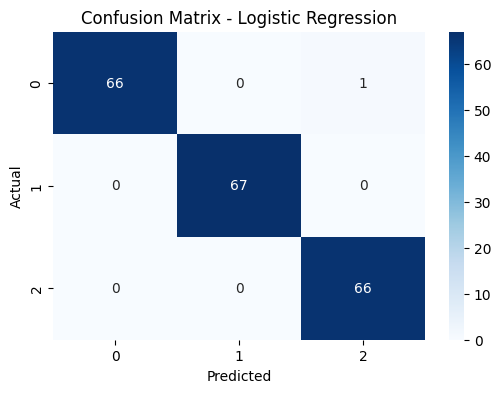

In [220]:
#Confusion Matrix (visualisation)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The confusion matrix shows, zero confusion between Low and other categories, zero confusion between Medium and other categories and just one case where a High-performing student was predicted as Medium. This tells us that the model clearly understands the boundaries between performance levels, with almost no overlap.

In conclusion, Logistic Regression was really good at classifying students into groups based on their performance, getting almost perfect accuracy and very few misclassifications. The results show that there are strong and clear patterns in the information that make it easy to tell the difference between groups of students with similar performances.

Since Logistic Regression achieved near-perfect performance, the next step focuses on feature engineering rather than immediately increasing model complexity.

# Feature Engineering

After feature improvement, then you can say:

“After strengthening feature representation, we tested more powerful classifiers to evaluate whether non-linear models could capture additional patterns.”

In [221]:
# Feature Engineering 

# Average Score
data["average_score"] = data["total_score"] / 3

In [222]:
# Performance Level
def performance_level(score):
    if score < 200:
        return "Low"
    elif score < 240:
        return "Medium"
    else:
        return "High"

data["performance_level"] = data["total_score"].apply(performance_level)

In [223]:
# Encoding binary categorical features

# Gender
data["gender_encoded"] = data["gender"].map({
    "female": 1,
    "male": 0
})

# Lunch Type 
data["lunch_encoded"] = data["lunch"].map({
    "standard": 1,
    "free/reduced": 0
})

# Test Preparations 
data["test_prep_encoded"] = data["test_preparation_course"].map({
    "completed": 1,
    "none": 0
})

In [224]:
# Encoding Parental Education 
education_map = {
    "some high school": 0,
    "high school": 1,
    "some college": 2,
    "associate's degree": 3,
    "bachelor's degree": 4,
    "master's degree": 5
}

data["parent_edu_encoded"] = data["parental_level_of_education"].map(education_map)

In [225]:
# Selecting final feature, creating x and y
features = [
    "math_score",
    "reading_score",
    "writing_score",
    "average_score",
    "gender_encoded",
    "lunch_encoded",
    "test_prep_encoded",
    "parent_edu_encoded"
]

X = data[features]
y = data["performance_level"]

In [226]:
X.head(), y.value_counts()

(   math_score  reading_score  writing_score  average_score  gender_encoded  \
 0          72             72             74      72.666667               1   
 1          69             90             88      82.333333               1   
 2          90             95             93      92.666667               1   
 3          47             57             44      49.333333               0   
 4          76             78             75      76.333333               0   
 
    lunch_encoded  test_prep_encoded  parent_edu_encoded  
 0              1                  0                   4  
 1              1                  1                   2  
 2              1                  0                   5  
 3              0                  0                   3  
 4              1                  0                   2  ,
 performance_level
 Low       444
 Medium    358
 High      198
 Name: count, dtype: int64)

Feature engineering has been applied to turn unprocessed educational data into useful predictors. This includes putting together performance scores, categorical encoding, and showing parental education in ordinal form. This improved interpretability and prepared the dataset for tree-based classification models.

# Decision Tree
After strengthening feature representation, more powerful classifiers are tested to evaluate whether non-linear models could capture additional patterns.

In [227]:
# Decision Tree

# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [228]:
# Descion Tree Classifier 
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

dt_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [229]:
# Prediction 
y_pred_dt = dt_model.predict(X_test)

In [230]:
# Evaluating the Model 

# 1 - Accuracy 
from sklearn.metrics import accuracy_score

accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_dt

1.0

In [231]:
# 2 - Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        39
         Low       1.00      1.00      1.00        89
      Medium       1.00      1.00      1.00        72

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [232]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix

cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

array([[39,  0,  0],
       [ 0, 89,  0],
       [ 0,  0, 72]])

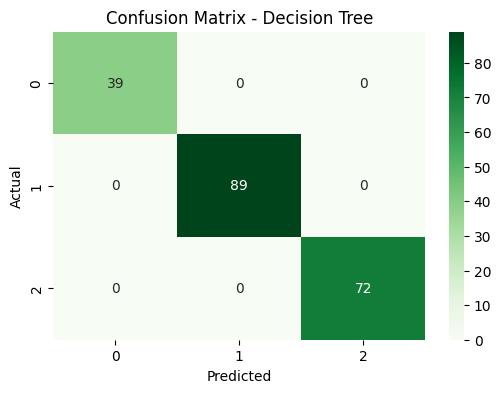

In [233]:
#Confusion Matrix (visualisation)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

The Decision Tree model achieved perfect classification accuracy in predicting student performance categories (Low, Medium, High) on the test dataset, indicating that the engineered features are highly informative, by learning clear threshold-based rules on the average_score feature and meaning that the model learned clear decision boundaries with strong relationships between scores and performance labels. However, this perfect score (1.0) serves as a warning rather than a straightforward success. It suggests potential overfitting, especially given that features are highly predictive and the dataset is not large. As a result, while the model performs perfectly on the training data, it may struggle with new, unseen students, indicating that it has memorised the answers rather than generalising effectively. To enhance generalisation and robustness, the use of ensemble-models like random forests are a next logical step.



# Random Forest 
Since a single decision tree can perfectly fit this dataset by memorization, a Random Forest model is trained next to examine whether ensemble learning offers improved robustness and stability, even when the underlying patterns are simple.

In [234]:
# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [235]:
# Evaluating the Model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:\n")
print(cm_rf)


Random Forest Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        39
         Low       1.00      1.00      1.00        89
      Medium       1.00      1.00      1.00        72

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:

[[39  0  0]
 [ 0 89  0]
 [ 0  0 72]]


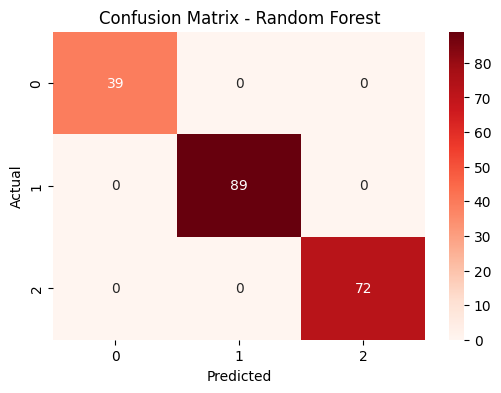

In [236]:
#Confusion Matrix (visualisation)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [237]:
# Feature Importance 
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
3,average_score,0.407239
1,reading_score,0.245404
2,writing_score,0.196911
0,math_score,0.129190
4,gender_encoded,0.006124
6,test_prep_encoded,0.005412
7,parent_edu_encoded,0.005137
5,lunch_encoded,0.004583


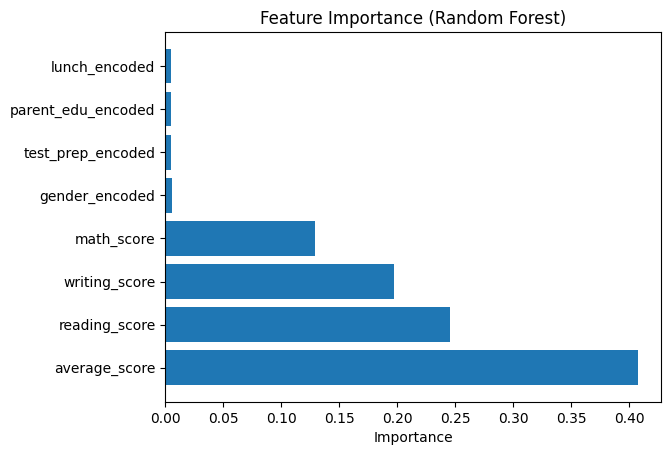

In [238]:
# Feature Importance Visual
import matplotlib.pyplot as plt

plt.figure()
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

The Random Forest model also achieved perfect accuracy, confirming that the dataset contains very strong and explicit patterns. Feature importance analysis reveals that the average_score dominates predictions, with other features contributing minimally. This shows that ensemble learning does not bring any further benefits when classification boundaries are already well defined.

The Random Forest classifier achieved perfect performance, correctly classifying every student in the test set. All classes (High, Medium, Low) show flawless precision, recall, and F1-scores.
This is this happening because, Random Forest is designed to reduce overfitting by combining multiple decision trees. However, in this dataset, student categories are already separated by very clear numerical thresholds. Because of this, even a more powerful ensemble model does not improve performance — it simply confirms how strongly structured the data is.

The confusion matrix tell us that the it contains values only on the diagonal, meaning:
- No High student was misclassified
- No Medium student was misclassified
- No Low student was misclassified

This indicates zero confusion between classes, which is rare in real-world classification problems.

# Final Conclusion
This project explored how different classification algorithms behave when applied to a highly structured educational dataset. Through Logistic Regression, Decision Tree, and Random Forest models, it became evident that student performance categories in this dataset are strongly driven by a small number of numerical features, particularly aggregated score measures.

All three classifiers performed exceptionally well, with the Decision Tree and Random Forest models producing perfect classification scores. Rather than showing improved generalisation, these results show that the dataset has clear, deterministic decision boundaries. When appropriate feature engineering was incorporated, the classification task became nearly entirely rule-based, allowing even simple models to perform successfully.

This highlights an important lesson in machine learning: high accuracy does not always imply model sophistication or real-world robustness. In structured datasets with explicit thresholds, advanced models may confirm patterns rather than uncover new insights.

Overall, this project demonstrates how dataset characteristics influence model behavior and emphasizes the importance of interpreting results beyond surface-level metrics. The findings reinforce the need for careful dataset selection and critical evaluation when building and comparing classification models.